In [134]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# Redefinir o alias para a função sum para evitar conflitos
#spark_sum = sum


In [135]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [136]:
# Inicializando la sesión Spark
spark = SparkSession.builder.appName("AnalisisCompletoDeDatos").getOrCreate()

# Ruta de la carpeta con los archivos Parquet
ruta = "/home/felipe/despliegue_analytica/files_parquet/"

# Listar todos los archivos Parquet en la carpeta
archivos_parquet = [f"{ruta}{f}" for f in os.listdir(ruta) if f.endswith('.parquet')]

# Leer y explorar cada archivo Parquet
for archivo in archivos_parquet:
    try:
        # Leer el archivo Parquet
        df = spark.read.option("spark.sql.parquet.int96AsTimestamp", "false").parquet(archivo)
        
        # Identificar y convertir columnas de tipo TIMESTAMP(NANOS) a String o Timestamp
        for col_name, col_type in df.dtypes:
            if col_type == 'timestamp':
                df = df.withColumn(col_name, col(col_name).cast('timestamp'))
        
        # Mostrar la información del DataFrame
        print(f"Explorando el archivo: {archivo}")
        print(f"Tamaño del DataFrame: {df.count()} filas, {len(df.columns)} columnas")
        print(f"Columnas del DataFrame: {df.dtypes}\n")
    
    except Exception as e:
        print(f"Error al procesar el archivo {archivo}: {e}\n")

Explorando el archivo: /home/felipe/despliegue_analytica/files_parquet/converted_olist_orders_dataset.parquet
Tamaño del DataFrame: 99441 filas, 8 columnas
Columnas del DataFrame: [('order_id', 'string'), ('customer_id', 'string'), ('order_status', 'string'), ('order_purchase_timestamp', 'timestamp'), ('order_approved_at', 'timestamp'), ('order_delivered_carrier_date', 'timestamp'), ('order_delivered_customer_date', 'timestamp'), ('order_estimated_delivery_date', 'timestamp')]

Explorando el archivo: /home/felipe/despliegue_analytica/files_parquet/olist_customers_dataset.parquet
Tamaño del DataFrame: 99441 filas, 5 columnas
Columnas del DataFrame: [('customer_id', 'string'), ('customer_unique_id', 'string'), ('customer_zip_code_prefix', 'string'), ('customer_city', 'string'), ('customer_state', 'string')]

Explorando el archivo: /home/felipe/despliegue_analytica/files_parquet/olist_order_payments_dataset.parquet
Tamaño del DataFrame: 103886 filas, 5 columnas
Columnas del DataFrame: [('

Se exploran las dimenciones de cada una de las bases de datos iniciales con las que se dispone, así como el nombre de cada una de las variables que estás contienen.

In [137]:
# Ruta de la carpeta donde se encuentran los archivos Parquet
folder_path = '/home/felipe/despliegue_analytica/files_parquet/'

# Listar archivos Parquet en el directorio
archivos_en_directorio = os.listdir(folder_path)

# Filtrar solo los archivos Parquet
archivos_parquet = [archivo for archivo in archivos_en_directorio if archivo.endswith('.parquet')]

# Cargar todos los DataFrames en un diccionario
dataframes = {}
for archivo in archivos_parquet:
    df_name = archivo.split('.')[0]  # Nombre del archivo sin extensión
    dataframes[df_name] = spark.read.parquet(os.path.join(folder_path, archivo))

# Combinar los DataFrames según los IDs y relaciones
df_joined = (dataframes['olist_orders_dataset']
             .join(dataframes['olist_order_items_dataset'], on='order_id', how='left')
             .join(dataframes['olist_order_payments_dataset'], on='order_id', how='left')
             .join(dataframes['olist_customers_dataset'], on='customer_id', how='left')
             .join(dataframes['olist_products_dataset'], on='product_id', how='left')
             .join(dataframes['olist_sellers_dataset'], on='seller_id', how='left')
             .join(dataframes['olist_order_reviews_dataset'], on='order_id', how='left'))

# Mostrar el número de filas y columnas del DataFrame combinado
tamano_df = df_joined.count()
num_columnas = len(df_joined.columns)

print(f"Tamaño del DataFrame combinado: {tamano_df} filas, {num_columnas} columnas")
print("Columnas del DataFrame combinado:", df_joined.columns)

Tamaño del DataFrame combinado: 119143 filas, 39 columnas
Columnas del DataFrame combinado: ['order_id', 'seller_id', 'product_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id', 'shipping_limit_date', 'price', 'freight_value', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


Para facilitar el analisis y expliración de los datos, de hace un merge entre las bases de datos originales de acuerdo a la key dispuesta para relacionar la información.

In [138]:
# Tamaño del DataFrame
num_rows = df_joined.count()
num_cols = len(df_joined.columns)
print("Número de filas:", num_rows)
print("Número de columnas:", num_cols)

# Estadísticas descriptivas
stats = df_joined.describe().toPandas()
print("Estadísticas descriptivas:\n", stats)

Número de filas: 119143
Número de columnas: 39


Estadísticas descriptivas:
   summary                          order_id                         seller_id  \
0   count                            119143                            118310   
1    mean                              None                              None   
2  stddev                              None                              None   
3     min  00010242fe8c5a6d1ba2dd792cb16214  0015a82c2db000af6aaaf3ae2ecb0532   
4     max  fffe41c64501cc87c801fd61db3f6244  ffff564a4f9085cd26170f4732393726   

                         product_id                       customer_id  \
0                            118310                            119143   
1                              None                              None   
2                              None                              None   
3  00066f42aeeb9f3007548bb9d3f33c38  00012a2ce6f8dcda20d059ce98491703   
4  fffe9eeff12fcbd74a2f2b007dde0c58  ffffe8b65bbe3087b653a978c870db99   

  order_status       order_item_id            

In [139]:
# Conteo de valores nulos por columna
null_counts = df_joined.select([col(c).isNull().cast("int").alias(c) for c in df_joined.columns]) \
    .groupBy().sum().collect()[0]
print("Conteo de valores nulos por columna:")
for col_name, null_count in zip(df_joined.columns, null_counts):
    print(f"{col_name}: {null_count}")

Conteo de valores nulos por columna:
order_id: 0
seller_id: 833
product_id: 833
customer_id: 0
order_status: 0
order_purchase_timestamp: 0
order_approved_at: 177
order_delivered_carrier_date: 2086
order_delivered_customer_date: 3421
order_estimated_delivery_date: 0
order_item_id: 833
shipping_limit_date: 833
price: 833
freight_value: 833
payment_sequential: 3
payment_type: 3
payment_installments: 3
payment_value: 3
customer_unique_id: 0
customer_zip_code_prefix: 0
customer_city: 0
customer_state: 0
product_category_name: 2542
product_name_lenght: 2542
product_description_lenght: 2542
product_photos_qty: 2542
product_weight_g: 853
product_length_cm: 853
product_height_cm: 853
product_width_cm: 853
seller_zip_code_prefix: 833
seller_city: 833
seller_state: 833
review_id: 997
review_score: 997
review_comment_title: 105154
review_comment_message: 68898
review_creation_date: 5864
review_answer_timestamp: 5866


In [140]:
# Tipos de variables
dtypes = df_joined.dtypes
print("Tipos de variables:")
for col_name, dtype in dtypes:
    print(f"{col_name}: {dtype}")

Tipos de variables:
order_id: string
seller_id: string
product_id: string
customer_id: string
order_status: string
order_purchase_timestamp: timestamp
order_approved_at: timestamp
order_delivered_carrier_date: timestamp
order_delivered_customer_date: timestamp
order_estimated_delivery_date: timestamp
order_item_id: int
shipping_limit_date: timestamp
price: double
freight_value: double
payment_sequential: int
payment_type: string
payment_installments: int
payment_value: double
customer_unique_id: string
customer_zip_code_prefix: string
customer_city: string
customer_state: string
product_category_name: string
product_name_lenght: int
product_description_lenght: int
product_photos_qty: int
product_weight_g: int
product_length_cm: int
product_height_cm: int
product_width_cm: int
seller_zip_code_prefix: string
seller_city: string
seller_state: string
review_id: string
review_score: string
review_comment_title: string
review_comment_message: string
review_creation_date: string
review_answer

In [141]:
# Primeras 5 filas del DataFrame
print("Primeras 5 filas del DataFrame:")
df_joined.show(5)

Primeras 5 filas del DataFrame:
+--------------------+--------------------+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+-------------------+-----+-------------+------------------+------------+--------------------+-------------+--------------------+------------------------+-------------+--------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+----------------------+--------------+------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|            order_id|           seller_id|          product_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order

* El análisis del DataFrame revela que contiene un total de 119,143 filas y 39 columnas, lo que sugiere una base de datos considerable para el estudio de órdenes de compra. 

* Las estadísticas descriptivas muestran que las fechas de las órdenes de compra varían desde el 5 de septiembre de 2016 hasta el 17 de octubre de 2018. Las columnas relacionadas presentan valores nulos, indicando que algunos pedidos no fueron entregados según lo previsto.

* En cuanto a las estadísticas numéricas, el precio medio de los productos es de 120.65 reales, con un valor de flete promedio de 20.03 reales. Sin embargo, se presentan discrepancias notables en los datos, ya que hay valores nulos en varias columnas, como order_approved_at, order_delivered_carrier_date, y order_delivered_customer_date, lo que puede complicar un análisis enfocado en de la eficiencia en la entrega (para este ejercicio el enfoque esta en predicion de precios y demanada, no eficiencias de entrega). 

* Además, el análisis muestra que las variables de longitud, peso y dimensiones de los productos también tienen una cantidad significativa de valores nulos, lo que podría limitar las conclusiones sobre la relación entre estas características y otros aspectos, como el precio o el tiempo de entrega.

* Los tipos de variables en el DataFrame incluyen una mezcla de datos categóricos y numéricos, así como datos temporales. En particular, se observa que la mayoría de las columnas son de tipo object, seguidas de float64 para los datos numéricos y datetime64 para las fechas. Por último, las primeras cinco filas del DataFrame proporcionan una visión inicial de la estructura de los datos, mostrando pedidos con información sobre el estado, las fechas de compra y entrega, así como los detalles del producto y del vendedor. Esto establece una base sólida para un análisis más profundo de los patrones de compra y entrega en la plataforma.

* Dado el considerable tamaño de valores nulos en las varaibles relacionadas a la calificación del producto y expriencia de usuario se determina descartar el uso de esta información para el analisis, pues eliminar los valores nulos o tener en cuenta lo pocos que se han dispuesto puede afectar la efectividad del modelo.

In [142]:
# Lista de columnas a eliminar
columnas_a_eliminar = [
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "review_id",
    "review_score",
    "review_comment_title",
    "review_comment_message",
    "review_creation_date",
    "review_answer_timestamp",
    "review_comment_message"  # Esta columna estaba duplicada, por lo que se eliminó una instancia
]

# Eliminar columnas del DataFrame
# Usamos el método drop de PySpark
num_rows_original = df_joined.count()
num_cols_original = len(df_joined.columns)

# Eliminar las columnas
df_joined_cleaned = df_joined.drop(*columnas_a_eliminar)

# Mostrar el tamaño del DataFrame antes y después
num_rows_cleaned = df_joined_cleaned.count()
num_cols_cleaned = len(df_joined_cleaned.columns)
print(f"Tamaño original: {num_rows_original} filas, {num_cols_original} columnas")
print(f"Tamaño después de eliminar columnas: {num_rows_cleaned} filas, {num_cols_cleaned} columnas")

Tamaño original: 119143 filas, 39 columnas
Tamaño después de eliminar columnas: 119143 filas, 31 columnas


In [143]:
# Conteo de valores nulos por columna
null_counts = df_joined_cleaned.select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in df_joined_cleaned.columns]
).collect()[0]

print("Conteo de valores nulos por columna:")
for col_name, null_count in null_counts.asDict().items():
    print(f"{col_name}: {null_count}")

Conteo de valores nulos por columna:
order_id: 0
seller_id: 833
product_id: 833
customer_id: 0
order_status: 0
order_purchase_timestamp: 0
order_approved_at: 177
order_estimated_delivery_date: 0
order_item_id: 833
shipping_limit_date: 833
price: 833
freight_value: 833
payment_sequential: 3
payment_type: 3
payment_installments: 3
payment_value: 3
customer_unique_id: 0
customer_zip_code_prefix: 0
customer_city: 0
customer_state: 0
product_category_name: 2542
product_name_lenght: 2542
product_description_lenght: 2542
product_photos_qty: 2542
product_weight_g: 853
product_length_cm: 853
product_height_cm: 853
product_width_cm: 853
seller_zip_code_prefix: 833
seller_city: 833
seller_state: 833


Despues de la depuración de varaibles con alto grado de valores nulos, se procede a eliminar los valores nulos de variables. Si bien existen grupos de tamañop considerable (como product_category_name con una cantidad de nulos de 2542), estos son se estiman relevantes para el entrenamiento del modelo, de manerta que se matienen las variables a costa de eliminar sus registros invalidos.

In [144]:
# Ruta donde se guardara el archivo
save_path = '/home/felipe/despliegue_analytica/files_parquet/'

# Eliminar filas con valores nulos en df_joined_cleaned
df_joined_cleaned_no_nulls = df_joined_cleaned.dropna()

# Mostrar el tamaño del DataFrame antes y después de eliminar valores nulos
tamaño_original = (df_joined_cleaned.count(), len(df_joined_cleaned.columns))
tamaño_sin_nulos = (df_joined_cleaned_no_nulls.count(), len(df_joined_cleaned_no_nulls.columns))

print(f"Tamaño original: {tamaño_original}")
print(f"Tamaño después de eliminar filas con valores nulos: {tamaño_sin_nulos}")

Tamaño original: (119143, 31)
Tamaño después de eliminar filas con valores nulos: (116583, 31)


In [145]:
# Obtener el DataFrame de conteo de nulos
conteo_nulos = df_joined_cleaned_no_nulls.select(
    [(df_joined_cleaned_no_nulls[column_name].isNull().cast("int")).alias(column_name) for column_name in df_joined_cleaned_no_nulls.columns]
)
conteo_nulos = conteo_nulos.groupBy().sum().collect()[0]

# Obtener los nombres de las columnas y el conteo de nulos
null_counts = {df_joined_cleaned_no_nulls.columns[i]: conteo_nulos[i] for i in range(len(conteo_nulos))}

# Imprimir el resultado
print("Conteo de valores nulos por columna:")
for column_name, count in null_counts.items():
    print(f"{column_name}: {count}")

Conteo de valores nulos por columna:
order_id: 0
seller_id: 0
product_id: 0
customer_id: 0
order_status: 0
order_purchase_timestamp: 0
order_approved_at: 0
order_estimated_delivery_date: 0
order_item_id: 0
shipping_limit_date: 0
price: 0
freight_value: 0
payment_sequential: 0
payment_type: 0
payment_installments: 0
payment_value: 0
customer_unique_id: 0
customer_zip_code_prefix: 0
customer_city: 0
customer_state: 0
product_category_name: 0
product_name_lenght: 0
product_description_lenght: 0
product_photos_qty: 0
product_weight_g: 0
product_length_cm: 0
product_height_cm: 0
product_width_cm: 0
seller_zip_code_prefix: 0
seller_city: 0
seller_state: 0


In [146]:
# Guardar el DataFrame limpio sin nulos en formato Parquet
save_path = '/home/felipe/Desktop/Uniandes/Terraform/despliegue_analytica/files_parquet'

df_joined_cleaned_no_nulls.write.mode("overwrite").parquet(os.path.join(save_path, 'df_joined_cleaned_no_nulls.parquet'))

print("DataFrame guardado con éxito en formato Parquet.")

DataFrame guardado con éxito en formato Parquet.


Se guarda la base de datos depurada sin valores nulos como "df_joined_cleaned_no_nulls.parquet"

In [147]:
# 1. Visualizar las dimensiones del DataFrame
num_filas = df_joined_cleaned_no_nulls.count()
num_columnas = len(df_joined_cleaned_no_nulls.columns)
print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")

Número de filas: 116583
Número de columnas: 31


In [148]:
# 2. Mostrar el esquema del DataFrame
df_joined_cleaned_no_nulls.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- payment_sequential: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: integer (nullable = true)
 |-- payment_value: double (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- product_category_name: string (nu

In [149]:
# 3. Describir las estadísticas descriptivas de las columnas numéricas
df_joined_cleaned_no_nulls.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------+------------------+------------------+------------------+------------------+------------+--------------------+------------------+--------------------+------------------------+-------------------+--------------+---------------------+-------------------+--------------------------+------------------+-----------------+------------------+------------------+------------------+----------------------+-----------+------------+
|summary|            order_id|           seller_id|          product_id|         customer_id|order_status|     order_item_id|             price|     freight_value|payment_sequential|payment_type|payment_installments|     payment_value|  customer_unique_id|customer_zip_code_prefix|      customer_city|customer_state|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty| product_weight_g| product_length_cm| product_height_cm|  product_wi

In [150]:
# 4. Mostrar las primeras filas del DataFrame
df_joined_cleaned_no_nulls.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+------------------------+-------------------+-----------------------------+-------------+-------------------+-----+-------------+------------------+------------+--------------------+-------------+--------------------+------------------------+-------------+--------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+----------------------+--------------+------------+
|            order_id|           seller_id|          product_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_estimated_delivery_date|order_item_id|shipping_limit_date|price|freight_value|payment_sequential|payment_type|payment_installments|payment_value|  customer_unique_id|customer_zip_code_prefix|customer_city|customer_state|product_category_name|product_name_lenght|product_de

In [151]:
# 5. Conteo de valores nulos por columna
null_counts = df_joined_cleaned_no_nulls.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df_joined_cleaned_no_nulls.columns
]).collect()[0]

print("Conteo de valores nulos por columna:")
for col_name, count in null_counts.asDict().items():
    print(f"{col_name}: {count}")


Conteo de valores nulos por columna:
order_id: 0
seller_id: 0
product_id: 0
customer_id: 0
order_status: 0
order_purchase_timestamp: 0
order_approved_at: 0
order_estimated_delivery_date: 0
order_item_id: 0
shipping_limit_date: 0
price: 0
freight_value: 0
payment_sequential: 0
payment_type: 0
payment_installments: 0
payment_value: 0
customer_unique_id: 0
customer_zip_code_prefix: 0
customer_city: 0
customer_state: 0
product_category_name: 0
product_name_lenght: 0
product_description_lenght: 0
product_photos_qty: 0
product_weight_g: 0
product_length_cm: 0
product_height_cm: 0
product_width_cm: 0
seller_zip_code_prefix: 0
seller_city: 0
seller_state: 0


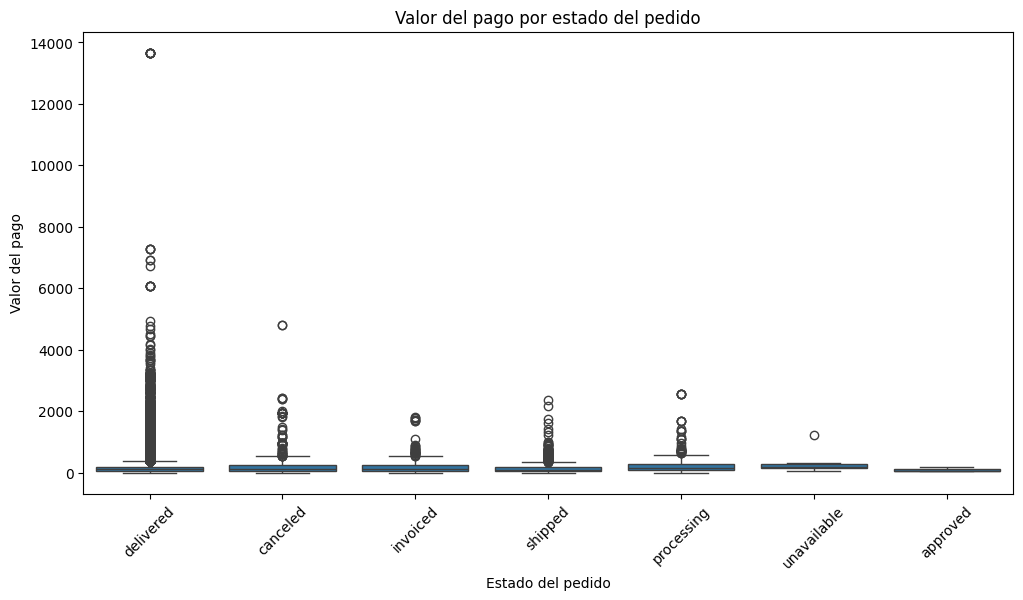

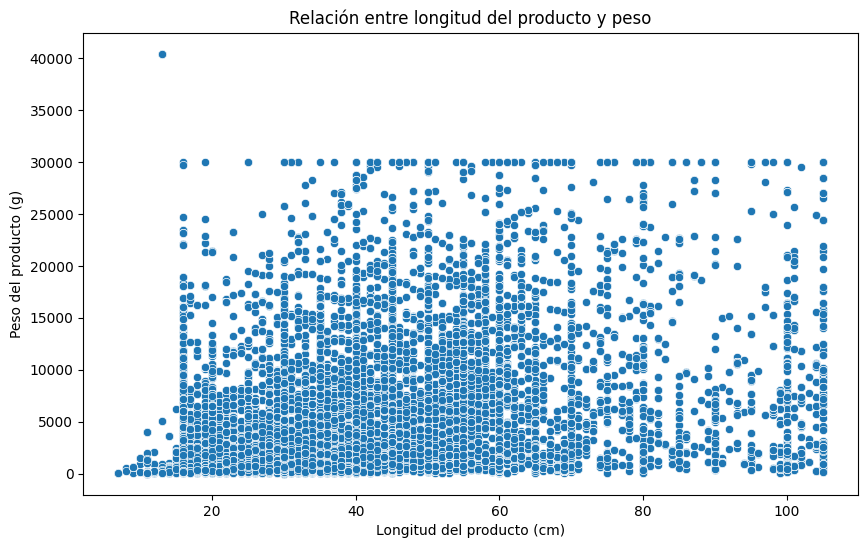

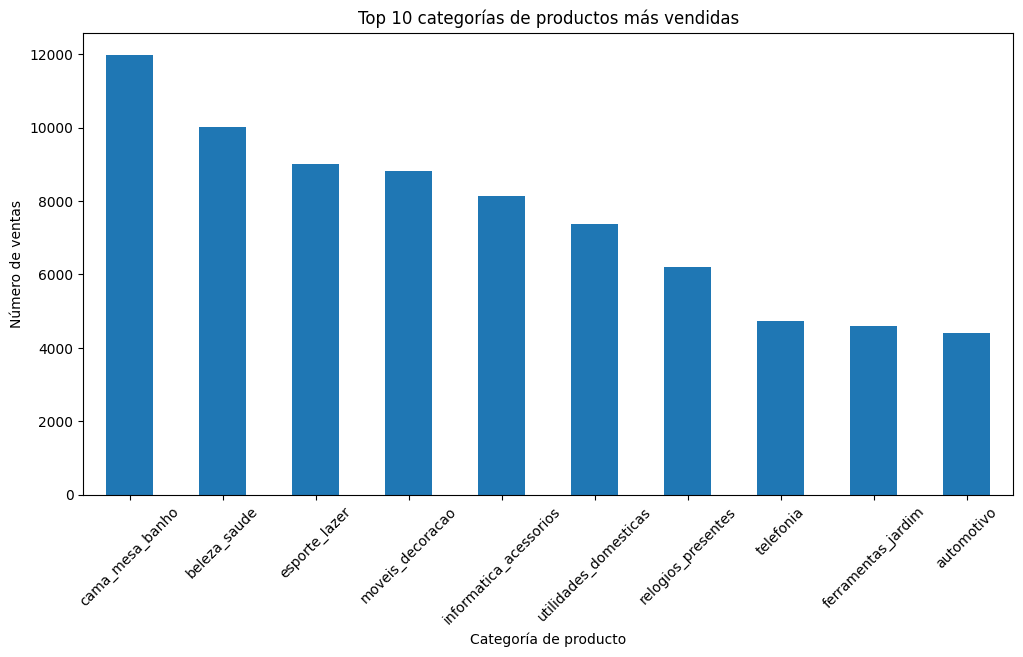

In [152]:
# Convertir el DataFrame a Pandas para visualizaciones
df_pandas = df_joined_cleaned_no_nulls.toPandas()

# Visualización de gráficos
# 5. Analizar la distribución de las calificaciones de revisión
if 'review_score' in df_pandas.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='review_score', data=df_pandas)
    plt.title('Distribución de las calificaciones de revisión')
    plt.xlabel('Calificación de revisión')
    plt.ylabel('Frecuencia')
    plt.show()

# 6. Analizar el tiempo de entrega
if 'order_delivered_customer_date' in df_pandas.columns and 'order_purchase_timestamp' in df_pandas.columns:
    df_pandas['delivery_time'] = (pd.to_datetime(df_pandas['order_delivered_customer_date']) - 
                                  pd.to_datetime(df_pandas['order_purchase_timestamp'])).dt.days
    plt.figure(figsize=(10, 6))
    sns.histplot(df_pandas['delivery_time'].dropna(), bins=30, kde=True)
    plt.title('Distribución del tiempo de entrega (días)')
    plt.xlabel('Días de entrega')
    plt.ylabel('Frecuencia')
    plt.show()

# 7. Relación entre el valor del pago y el estado del pedido
if 'payment_value' in df_pandas.columns and 'order_status' in df_pandas.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='order_status', y='payment_value', data=df_pandas)
    plt.title('Valor del pago por estado del pedido')
    plt.xlabel('Estado del pedido')
    plt.ylabel('Valor del pago')
    plt.xticks(rotation=45)
    plt.show()

# 8. Analizar la relación entre las dimensiones del producto y su peso
if 'product_weight_g' in df_pandas.columns and 'product_length_cm' in df_pandas.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='product_length_cm', y='product_weight_g', data=df_pandas)
    plt.title('Relación entre longitud del producto y peso')
    plt.xlabel('Longitud del producto (cm)')
    plt.ylabel('Peso del producto (g)')
    plt.show()

# 9. Agrupar por categoría de producto y contar
if 'product_category_name' in df_pandas.columns:
    category_counts = df_pandas['product_category_name'].value_counts()
    plt.figure(figsize=(12, 6))
    category_counts.head(10).plot(kind='bar')
    plt.title('Top 10 categorías de productos más vendidas')
    plt.xlabel('Categoría de producto')
    plt.ylabel('Número de ventas')
    plt.xticks(rotation=45)
    plt.show()

* Las estadísticas descriptivas de las columnas numéricas del DataFrame revelan información clave sobre los datos. En cuanto a los precios, la media es de 120.93, con un mínimo de 0.85 y un máximo de 6735.00; la desviación estándar es de 184.19. En lo que respecta al valor de flete, la media es de 20.08, el mínimo es 0.00 y el máximo alcanza 409.68, con una desviación estándar de 15.87. Las fechas de compra muestran una fecha mínima de 2016-09-05 y una máxima de 2018-09-03, con un promedio de 2017-12-31.

* Al visualizar las primeras filas del DataFrame, se pueden observar ejemplos concretos de los datos, confirmando que las columnas están correctamente pobladas. A partir de esta información, se pueden considerar diversas áreas de análisis, como el estudio de tendencias de ventas a lo largo del tiempo utilizando las fechas de compra para identificar patrones estacionales, el análisis de los productos más vendidos mediante product_id y order_item_id, y la evaluación del impacto del flete en las ventas comparando price y freight_value.

* Grafica 1 / Valor del pago por estado del pedido: Esta gráfica presenta la distribución del valor del pago según diferentes estados del pedido, como "delivered", "shipped", "invoiced", "processing", etc. La mayoría de los pagos están concentrados en valores bajos, pero existen algunos valores atípicos (outliers) que alcanzan hasta los 14,000. En particular, el estado "delivered" parece tener una mayor variabilidad y más valores atípicos que el resto de los estados, lo que sugiere que hay una amplia gama de pagos en pedidos entregados, posiblemente debido a diferencias en los tipos de productos o en el tamaño de los pedidos.

* Grafica 2 / Relación entre longitud del producto y peso: Esta gráfica muestra la relación entre la longitud (en cm) y el peso (en gramos) de los productos. A simple vista, no parece haber una relación clara o lineal entre la longitud y el peso; los puntos están distribuidos de manera dispersa. Sin embargo, se observa que a medida que la longitud aumenta, el peso de los productos tiende a ser más variable, y algunos productos de longitud media (alrededor de 50-80 cm) alcanzan pesos altos, lo cual puede indicar que los productos más largos no siempre son más pesados.

* Grafica 3 / Top 10 productos más vendidos según su categoria: Se observa que las categorías de hogaar, belleza, bienestar y tecnología liderán las ventas del market place Olist.

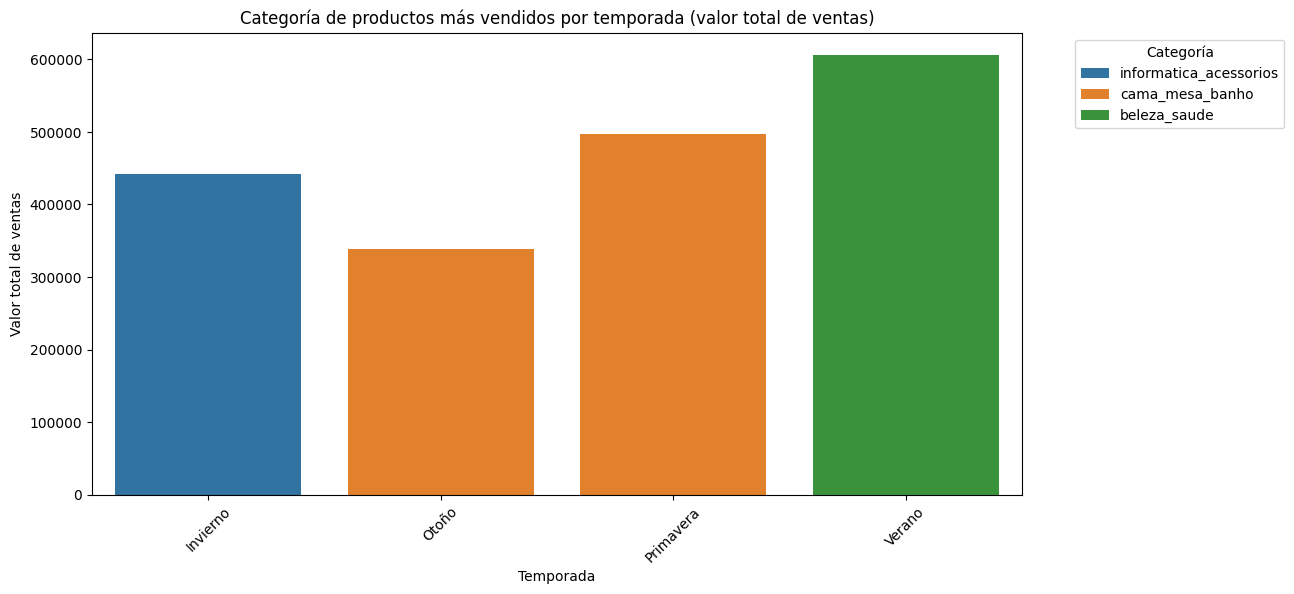

In [153]:
# Asegurarse de que las fechas están en formato datetime en PySpark
df_joined_cleaned_no_nulls = df_joined_cleaned_no_nulls.withColumn(
    'order_purchase_timestamp', col('order_purchase_timestamp').cast('timestamp')
)

# Extraer el mes de la fecha de compra
df_joined_cleaned_no_nulls = df_joined_cleaned_no_nulls.withColumn(
    'month', month(col('order_purchase_timestamp'))
)

# Función para asignar la temporada
df_joined_cleaned_no_nulls = df_joined_cleaned_no_nulls.withColumn(
    'season',
    when(col('month').isin([12, 1, 2]), 'Invierno')
    .when(col('month').isin([3, 4, 5]), 'Primavera')
    .when(col('month').isin([6, 7, 8]), 'Verano')
    .otherwise('Otoño')
)

# Calcular el valor total de ventas (si ya existe la columna 'payment_value')
if 'payment_value' in df_joined_cleaned_no_nulls.columns:
    df_joined_cleaned_no_nulls = df_joined_cleaned_no_nulls.withColumn('total_value', col('payment_value'))

# Agrupar por temporada y categoría y sumar las ventas
seasonal_sales = df_joined_cleaned_no_nulls.groupBy('season', 'product_category_name').agg(
    spark_sum('total_value').alias('total_value')
)

# Convertir a Pandas para la visualización
seasonal_sales_pd = seasonal_sales.toPandas()

# Crear un índice temporal único en el DataFrame Pandas
seasonal_sales_pd['temp_index'] = range(len(seasonal_sales_pd))
seasonal_sales_pd.set_index('temp_index', inplace=True)

# Calcular los índices de los productos más vendidos por temporada
idx_max = seasonal_sales_pd.groupby('season')['total_value'].idxmax()

# Obtener los productos más vendidos por temporada usando los índices calculados
top_products = seasonal_sales_pd.loc[idx_max].reset_index(drop=True)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='season', y='total_value', hue='product_category_name')
plt.title('Categoría de productos más vendidos por temporada (valor total de ventas)')
plt.xlabel('Temporada')
plt.ylabel('Valor total de ventas')
plt.xticks(rotation=45)
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

La grafica de categoria de producto vendido por temporeda sugiere que "beleza_saude" tiene una gran demanda tanto en primavera como en verano, mientras que en invierno se observa un aumento en la venta de productos tecnológicos. Esto puede reflejar una estacionalidad en las preferencias de los clientes, probablemente impulsada por factores como el clima o eventos de temporada.

In [ ]:
# Seleccionar solo las columnas numéricas
numeric_columns = [col_name for col_name, dtype in df_joined_cleaned_no_nulls.dtypes if dtype in ("double", "int")]

# Convertir el DataFrame de PySpark a Pandas para análisis de correlación
numeric_df = df_joined_cleaned_no_nulls.select(numeric_columns).toPandas()

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()
price_correlation = correlation_matrix['price'].drop(labels=['payment_value', 'total_value'], errors='ignore')

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

# Imprimir la correlación de 'price' con otras columnas
print(price_correlation)

* A partir del analisis de correolación, en primer lugar, el valor de flete presenta una correlación positiva moderada de 0.416653 con el precio. Esto sugiere que los productos más caros tienden a tener mayores costos de envío, lo que podría deberse al tamaño, peso o distancia de entrega de los mismos.

* Otro aspecto destacado es la correlación positiva con el número de cuotas de pago, que tiene un valor de 0.279394. Esto indica que, a medida que aumenta el número de cuotas, el precio de los artículos también tiende a ser más alto. Esta relación sugiere que los productos de mayor precio a menudo son adquiridos a través de planes de pago a plazos.

* La longitud de las descripciones de los productos también muestra una correlación positiva, aunque más débil, de 0.201853. Esto implica que los productos con descripciones más extensas suelen tener precios ligeramente más altos, lo que podría estar relacionado con la presencia de más detalles o características que destacan su valor.

* Asimismo, el peso del producto tiene una correlación positiva moderada de 0.340408 con el precio. Este hallazgo indica que los productos más pesados tienden a ser más caros, lo cual es coherente con la idea de que los artículos de mayor tamaño o peso generalmente tienen un costo más elevado. Las dimensiones del producto, como la altura (0.224383), el ancho (0.172371) y la longitud (0.145765), también muestran correlaciones positivas, aunque más débiles. Esto sugiere que los productos de mayor tamaño tienden a tener precios más altos, alineándose con la noción de que el tamaño es un factor importante en la determinación del costo.

* Por otro lado, el identificador del artículo del pedido presenta una correlación negativa débil de -0.060448 con el precio, lo que indica que no existe una relación significativa entre estas dos variables. Esto sugiere que el número de identificación del artículo no influye en el precio del producto.